In [1]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import sqlite3
from mpl_toolkits.mplot3d import Axes3D
sns.set()
blue, green, red = sns.color_palette()[:3]

%matplotlib inline
%run Utils.ipynb

In [2]:
# Connect to the database
DB_PATH = '../resources/capstone_db.sqlite'
db = sqlite3.connect(DB_PATH)

# Get a cursor
cursor = db.cursor()

## 1. EDA of the stellar properties

We will explore the stellar properties even if we expect these features to be weak predictors. Indeed, it sounds naive at best to think that it's possible to predict the presence of an exoplanet only by knowing their hosting star temperature, radius and few more properties. However, we can also expect that dwarf and giant stars have lower probability to host exoplanets. Because the Kepler mission was to monitor stars similar to the Sun, there are probably no giant and dwarf stars in our dataset but it doesn't mean that we can't discover some trends among the biased population it represents. We could improve the accuracy of our models few percents, maybe...

The goals of this EDA are :

* Compute the features skewness and kurtosis and engineer transformed variable when necessary 
* Plot their histograms and distributions splitted by label and false positive subcategories
* Engineer threshold indicator variables when the distributions show some trends
* Discover potential correlations with pairplots and multivariate scatter plots
* Drop potential outliers

In [3]:
# Load the classification target variables and the stellar properties
query = '''
SELECT
    ts.kepoi_name,
    ts.kepid,
    ts.fpflag_bitstring,
    kois.koi_disposition,
    sp.teff,
    sp.logg,
    sp.feh,
    sp.radius,
    sp.ebminusv,
    sp.av,
    sp.numtces
FROM
         tce_status AS ts
    JOIN stellar_properties AS sp ON (ts.kepid = sp.kepid)
    JOIN kois_activity_table AS kois ON (ts.kepoi_name = kois.kepoi_name)
WHERE
    ts.excluded = 0
'''
df = pd.read_sql_query(query, db)
print('KOIs Activity Table Shape:', df.shape)
df.head()

KOIs Activity Table Shape: (4882, 11)


,kepoi_name,kepid,fpflag_bitstring,koi_disposition,teff,logg,feh,radius,ebminusv,av,numtces
0,K00752.01,010797460,0000,CONFIRMED,5850.0,4.426,0.14,1.040,0.142,0.441,2
1,K00752.02,010797460,0000,CONFIRMED,5850.0,4.426,0.14,1.040,0.142,0.441,2
2,K00755.01,010854555,0000,CONFIRMED,6031.0,4.438,0.07,1.046,0.142,0.440,1
3,K00114.01,006721123,0110,FALSE POSITIVE,6227.0,3.986,0.00,1.958,0.104,0.321,2
4,K00010.01,006922244,0000,CONFIRMED,6225.0,4.169,-0.04,1.451,0.096,0.297,1


First, we want to check if they follow normal distribution by computing the skewness and kurtosis of their distribution. We will also compute the skewness and kurtosis of their respective logarithmic and square root transformed variables :

In [4]:
# Get skewness and kurtosis of the stellar variables and their log10 and sqrt transformations
eda_skewness_kurtosis(df.select_dtypes(include=np.number))

,Kurtosis,Kurtosis log10,Kurtosis sqrt,Skewness,Skewness log10,Skewness sqrt
teff,5.043109,3.069290,3.438524,0.310087,-0.739434,-0.255380
logg,32.544669,170.795260,67.103030,-4.455238,-10.448613,-6.411560
feh,5.464726,NaN,-0.619858,-1.258626,NaN,0.019081
radius,505.977762,18.760718,158.099139,20.714787,3.070897,10.587789
ebminusv,0.805599,2.483717,0.528808,0.222837,-1.139527,-0.405714
av,0.804451,2.498041,0.529126,0.222079,-1.141287,-0.406551
numtces,7.004434,-0.214216,1.961871,2.258696,0.850742,1.398191


To have variables with distributions as similar as possible to normal distributions, we have to:

* engineer an effective temperature, square root transformed variable (`teff_sqrt`)
* engineer a stellar radius, log10 transformed variable (`radius_log10`)

In [5]:
# Engineer the transformed variables 
df['teff_sqrt'] = np.sqrt(df.teff)
df['radius_log10'] = np.log10(df.radius)

### 1.1 Effective temperature

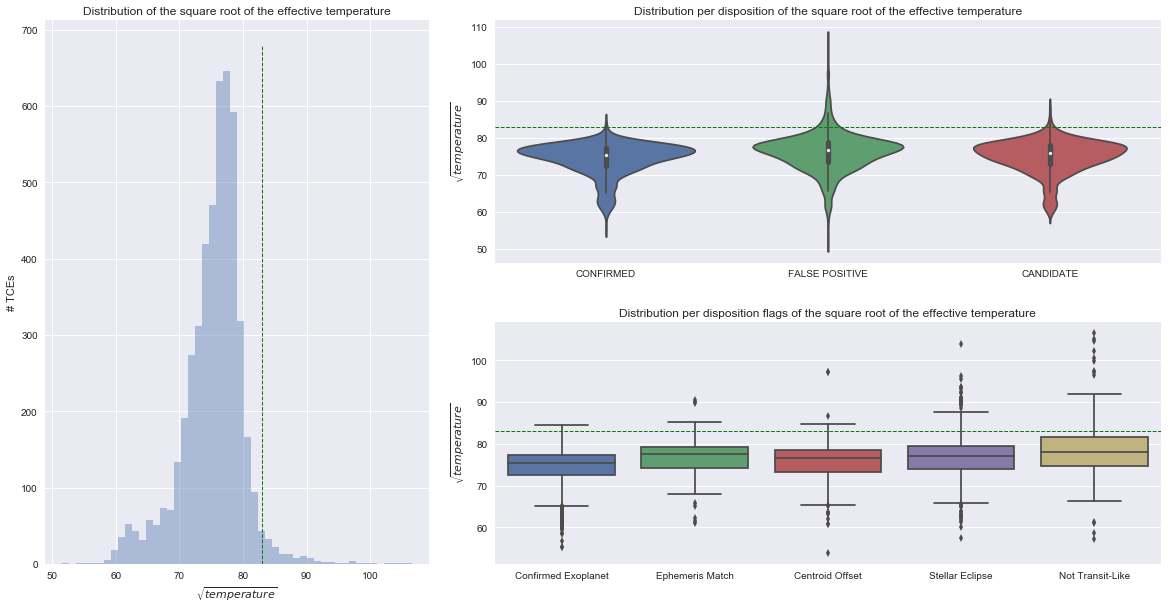

In [6]:
teff_max_threshold = 83
eda_plot_dist(df, 
              var='teff_sqrt', 
              var_label='$\sqrt{temperature}$', 
              var_title='square root of the effective temperature', 
              min_threshold=None,
              max_threshold=teff_max_threshold
             )

Exoplanets tends to orbit around stars with lower temperatures.  
We can engineer a threshold indicator variable represented by the green dashed line, following the rule :

> 1 when \\(\sqrt{temperature} \geq 83\\) (false positive indicator)  
> 0 else

In [7]:
# Engineer a threshold temperature indicator variable
df['teff_maxthresh'] = (df.teff_sqrt >= teff_max_threshold).astype(int) 

### 1.2 Surface gravity

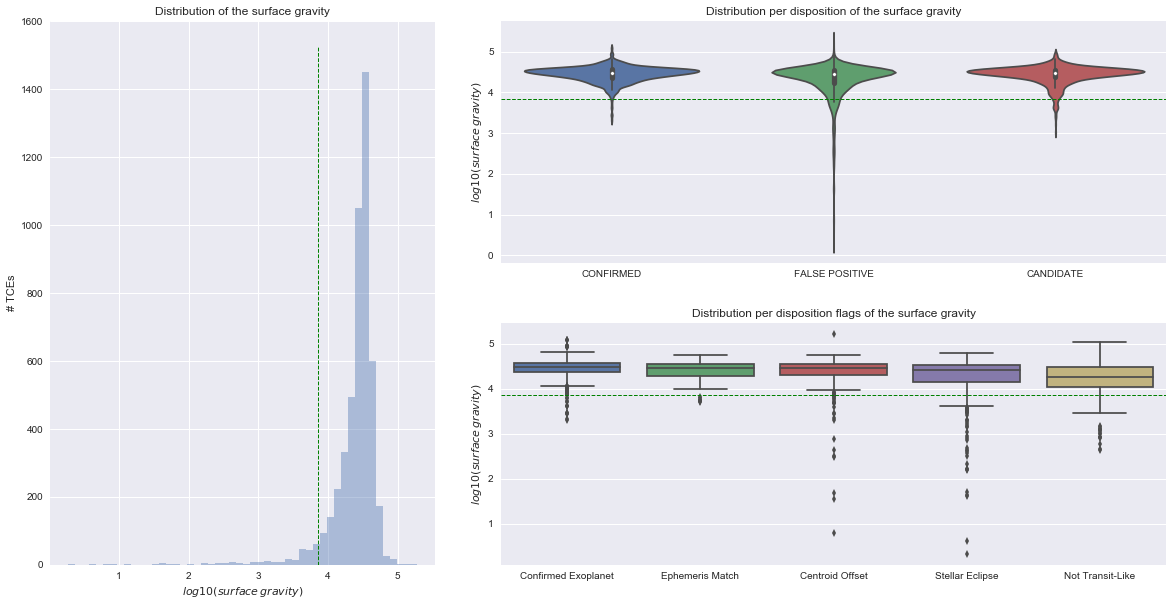

In [8]:
logg_min_threshold = 3.85
eda_plot_dist(df, 
              var='logg', 
              var_label='$log10(surface\,gravity)$', 
              var_title='surface gravity', 
              min_threshold=logg_min_threshold,
              max_threshold=None
             )

Stars with low surface gravity tend to be the host of false positives only.  
We can engineer a threshold indicator variable represented by the green dashed line, following the rule :

> 1 when \\(\log_{10}(gravity) \leq 3.85\\) (false positive indicator)  
> 0 else

In [9]:
# Engineer a threshold surface gravity indicator variable
df['logg_minthresh'] = (df.logg <= logg_min_threshold).astype(int) 

### 1.3 Stellar radius

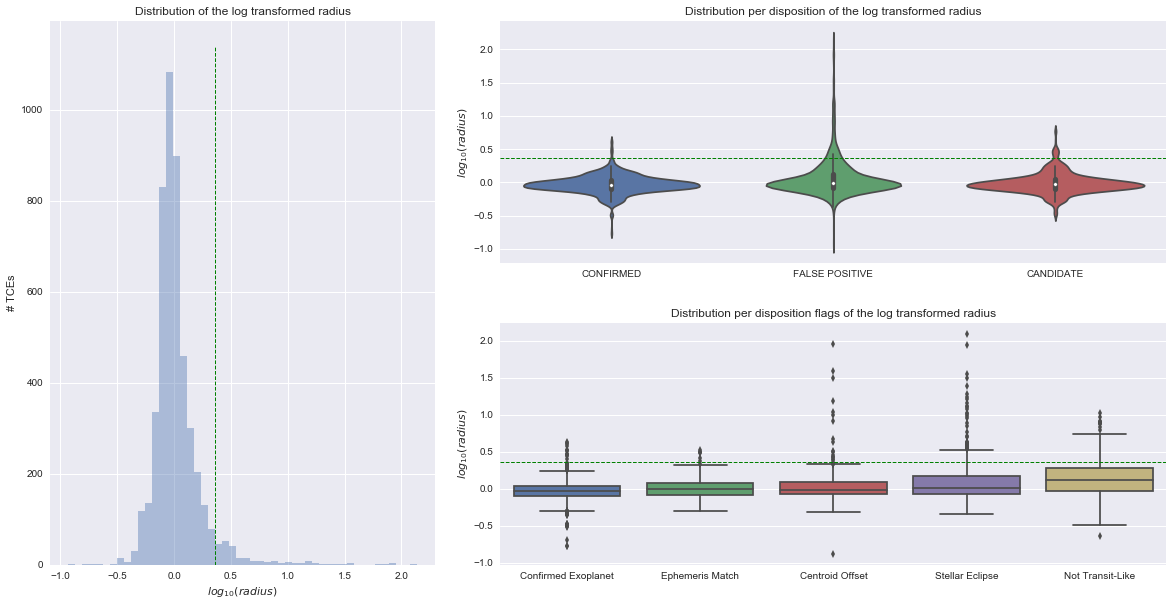

In [10]:
radius_max_threshold = 0.36
eda_plot_dist(df, 
              var='radius_log10', 
              var_label='$log_{10}(radius)$', 
              var_title='log transformed radius', 
              min_threshold=None,
              max_threshold=radius_max_threshold
             )

The stellar radius variable clearly demonstrates the bias of our dataset. Most of the stars have size similar to the Sun. The probability to find exoplanets around stars 3 times bigger than the Sun is low.

We can engineer a threshold indicator variable represented by the green dashed line, following the rule :

> 1 when \\(\log_{10}(radius) \geq 0.36\\) (false positive indicator)  
> 0 else

In [11]:
# Engineer a threshold radius indicator variable
df['radius_maxthresh'] = (df.radius_log10 >= radius_max_threshold).astype(int) 

In [12]:
# Drop outliers TCEs with log(radius) < -0.6
filter = (df.radius_log10 < -0.6)
indices = df[filter].index
kepoi_names = list(df[filter].kepoi_name.values)

df.drop(axis=0, index=indices, inplace=True)
db_exclude_tces(cursor, kepoi_names, 'OUTLIER_RADIUS')
print('Number of TCEs dropped: ', filter.sum())
print('DataFrame Shape: ', db_get_number_tces(cursor, excluded=False))

Number of TCEs dropped:  7
DataFrame Shape:  (4875,)


The stellar radius distributions look similar to the surface gravity distributions but inverted.  
These two features are probably correlated, it would make sense that bigger stars have lower surface gravity :

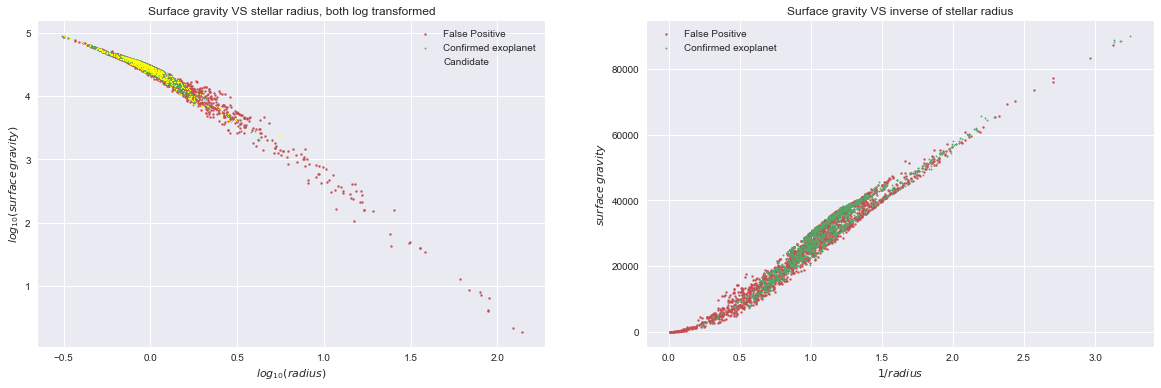

In [13]:
false_positives = df.koi_disposition == 'FALSE POSITIVE'
candidates = df.koi_disposition== 'CANDIDATE'
exoplanets = df.koi_disposition== 'CONFIRMED'

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Surface gravity VS stellar radius, log transformed
ax[0].scatter(df.radius_log10[false_positives], df.logg[false_positives], s=4, color=red, label='False Positive')
ax[0].scatter(df.radius_log10[exoplanets], df.logg[exoplanets], s=2, color=green, label='Confirmed exoplanet')
ax[0].scatter(df.radius_log10[candidates], df.logg[candidates], s=1, color='yellow', label='Candidate')
ax[0].legend()
ax[0].set_xlabel('$log_{10}(radius)$')
ax[0].set_ylabel('$log_{10}(surface\,gravity)$')
ax[0].set_title('Surface gravity VS stellar radius, both log transformed')

ax[1].scatter((1/df.radius[false_positives]), np.power(10, df.logg[false_positives]), s=4, color=red, label='False Positive')
ax[1].scatter((1/df.radius[exoplanets]), np.power(10, df.logg[exoplanets]), s=2, color=green, label='Confirmed exoplanet')
ax[1].legend()
ax[1].set_xlabel('$1/radius$')
ax[1].set_ylabel('$surface\,gravity$')
ax[1].set_title('Surface gravity VS inverse of stellar radius')
plt.show()

As expected, the two features are inversely proportional. On the right plot, we can see that the surface gravity is nearly linearly proportional to the inverse of the stellar radius. I would expect the surface gravity linearly proportional to the inverse of the square of the radius... I don't explain it...

The two variables are nearly colinear and keeping both will probably not help our models.  
Spoiler: We will only keep the stellar radius and its associated threshold

### 1.4 Reddening and extinction

We already know that the reddening and extinction are colinear variables. We will only keep the reddening feature to train our models.

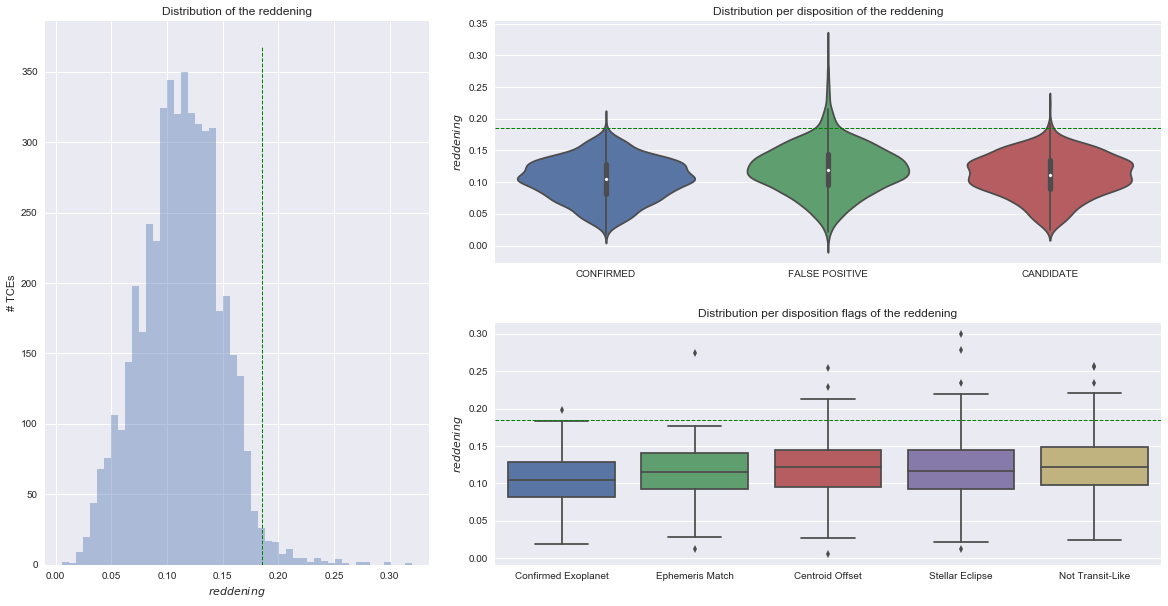

In [14]:
ebminusv_max_threshold = 0.185
eda_plot_dist(df, 
              var='ebminusv', 
              var_label='$reddening$', 
              var_title='reddening', 
              min_threshold=None,
              max_threshold=ebminusv_max_threshold
             )

Reddening tends to be lower for stars hosting exoplanets. It's maybe because the nebula from which the stars are born have also formed planets. The resulting dust cloud being less dense, the light is also less scattered...

We can engineer a threshold indicator variable represented by the green dashed line, following the rule :

> 1 when \\(reddening \geq 0.185\\) (false positive indicator)  
> 0 else

In [15]:
# Engineer a threshold reddening indicator variable
df['ebminusv_maxthresh'] = (df.ebminusv >= ebminusv_max_threshold).astype(int) 

### 1.5 Metallicity

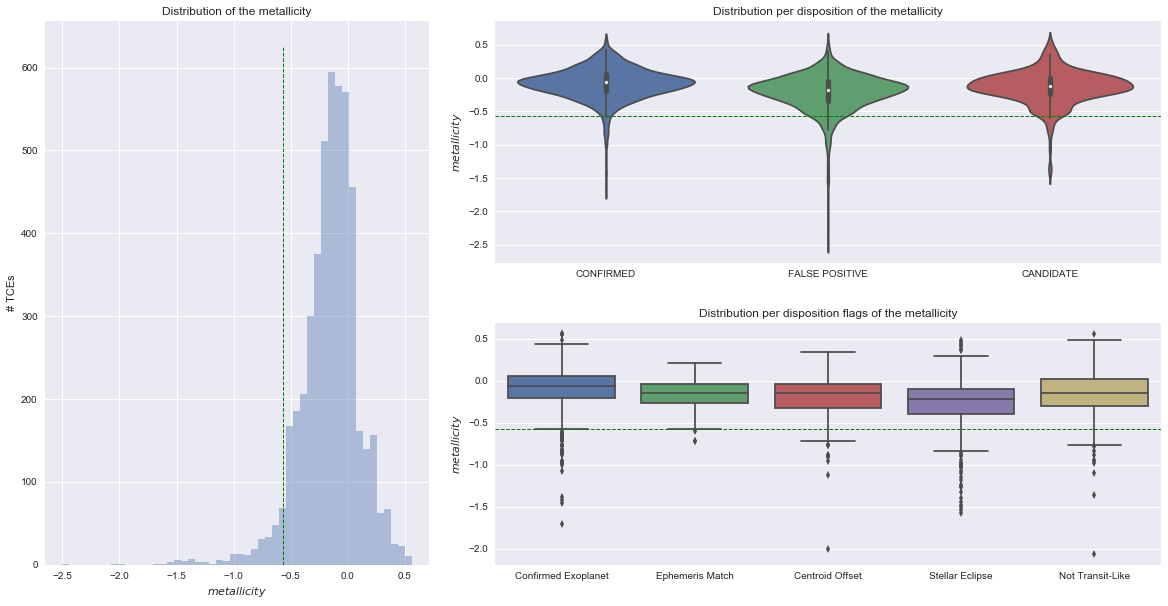

In [16]:
feh_min_threshold = -0.57
eda_plot_dist(df,  
              var='feh', 
              var_label='$metallicity$', 
              var_title='metallicity', 
              min_threshold=feh_min_threshold,
              max_threshold=None
             )

Stars hosting exoplanets tends to have higher metallicity, particularly compared to stars hostings stellar eclipse false positive TCEs.

We can engineer a threshold indicator variable represented by the green dashed line, following the rule :

> 1 when \\(metallicity \leq -0.57\\) (false positive indicator)  
> 0 else

In [17]:
# Engineer a threshold reddening indicator variable
df['feh_minthresh'] = (df.feh <= feh_min_threshold).astype(int) 

### 1.6 Pairplots

Now, we know more about the variables distributions, it's time to investigate about their relationships.  
Pairplots are an efficient way to visualize and explain them.

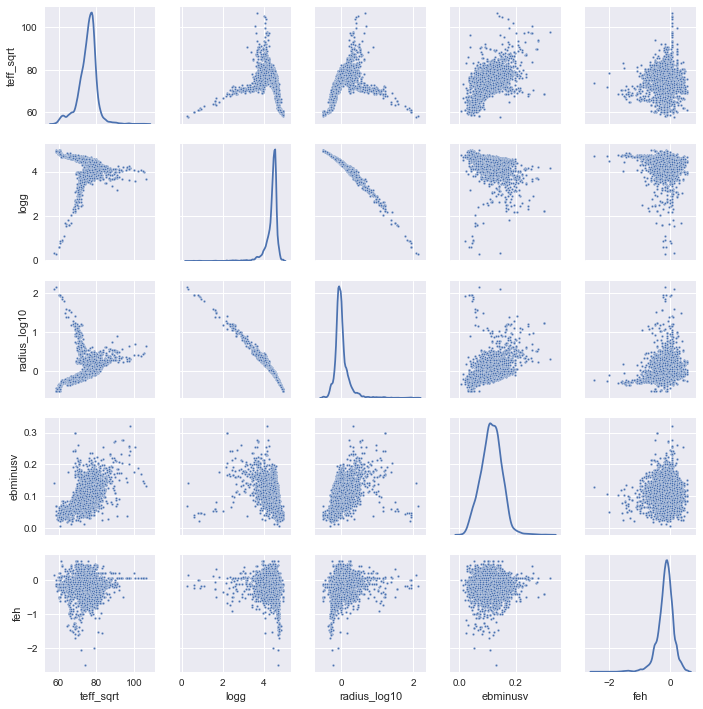

In [18]:
vars = ['teff_sqrt',
        'logg',
        'radius_log10',
        'ebminusv',
        'feh',
       ]

# Plot stellar properties pairwise relationships
sns.pairplot(df, kind='scatter', diag_kind='kde', x_vars=vars, y_vars=vars, size=2, plot_kws={"s": 6})
plt.show()

The following relationships looks particularly interesting and could show some clustering patterns :

* temperature VS radius
* metallicity VS radius
* reddening VS temperature

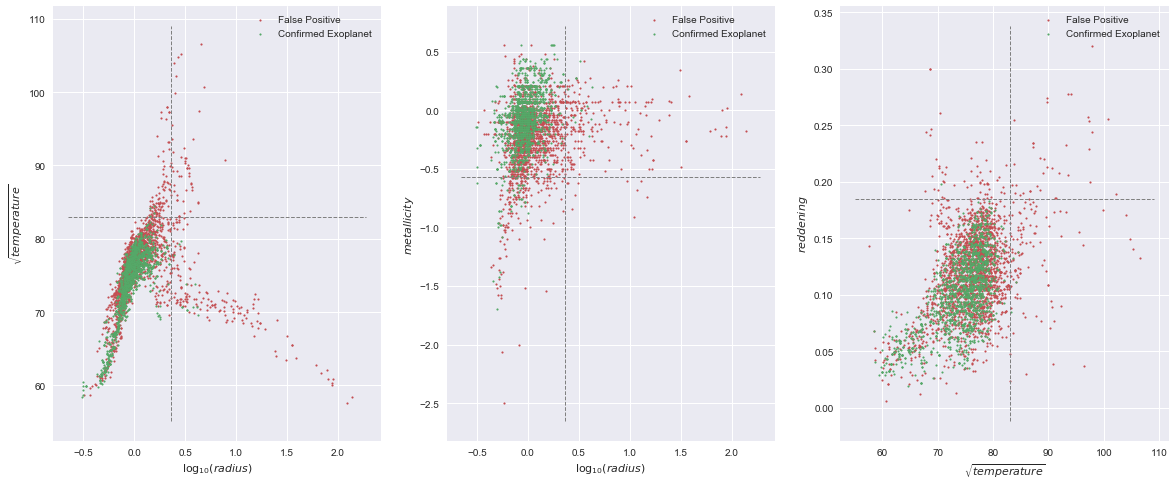

In [19]:
# Exoplanet & False positive filters
false_positives = df.koi_disposition == 'FALSE POSITIVE'
exoplanets = df.koi_disposition == 'CONFIRMED'

plots = [('radius_log10', 'teff_sqrt', '$\log_{10}(radius)$', '$\sqrt{temperature}$', radius_max_threshold, teff_max_threshold), 
         ('radius_log10', 'feh', '$\log_{10}(radius)$', '$metallicity$', radius_max_threshold, feh_min_threshold), 
         ('teff_sqrt', 'ebminusv', '$\sqrt{temperature}$', '$reddening$', teff_max_threshold, ebminusv_max_threshold)]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))
for i in range(3):
    xvar, yvar, xlabel, ylabel, xthresh, ythresh = plots[i]
    ax[i].scatter(df.loc[false_positives, xvar], df.loc[false_positives, yvar], s=3, color=red, label='False Positive')
    ax[i].scatter(df.loc[exoplanets, xvar], df.loc[exoplanets, yvar], s=3, color=green, label='Confirmed Exoplanet')
    ax[i].set_xlabel(xlabel)
    ax[i].set_ylabel(ylabel)
    if xthresh:
        ax[i].plot([xthresh, xthresh], ax[i].get_ylim(), color='gray', linestyle='--', linewidth=1)
    if ythresh:
        ax[i].plot(ax[i].get_xlim(), [ythresh, ythresh], color='gray', linestyle='--', linewidth=1)
    ax[i].legend()

The gray dashed lines are the threshold previously defined. The exoplanets form a less compact cluster but unfortunatly it always overlap the more spreaded false positives cluster.

We can maybe explain the following trends :

* left plot: bigger stars have lower effective temperature because their surface grows as the square of their radius. However, their producted energy don't grow as quickly in function of their radius. The density of the star could probably explain the split at (0.2, 80)

* right plot: reddening and effective temperature are positively correlated because higher is the star temperature, shorter is the main wavelength emitted. Short wavelengths are more scattered than high wavelengths, so the positive correlation. 

### 1.7 Save the engineered variables in the database

In [20]:
# list of engineered variables
cols = [
    'teff_sqrt',
    'radius_log10',
    'teff_maxthresh',
    'logg_minthresh',
    'radius_maxthresh',
    'ebminusv_maxthresh',
    'feh_minthresh'
]

# save the engineered variable in a temporary table
df.loc[:, ['kepoi_name'] + cols].to_sql(name='temp', con=db, if_exists='replace', index=False)

# add columns in the status database table
query = "ALTER TABLE tce_status ADD COLUMN teff_sqrt REAL;"
cursor.execute(query)
query = "ALTER TABLE tce_status ADD COLUMN radius_log10 REAL;"
cursor.execute(query)
query = "ALTER TABLE tce_status ADD COLUMN teff_maxthresh INTEGER DEFAULT 0;"
cursor.execute(query)
query = "ALTER TABLE tce_status ADD COLUMN logg_minthresh INTEGER DEFAULT 0;"
cursor.execute(query)
query = "ALTER TABLE tce_status ADD COLUMN radius_maxthresh INTEGER DEFAULT 0;"
cursor.execute(query)
query = "ALTER TABLE tce_status ADD COLUMN ebminusv_maxthresh INTEGER DEFAULT 0;"
cursor.execute(query)
query = "ALTER TABLE tce_status ADD COLUMN feh_minthresh INTEGER DEFAULT 0;"
cursor.execute(query)

# load the data 
for col in cols:
    query = "UPDATE tce_status SET " + col + " = (SELECT " + col + " FROM temp WHERE tce_status.kepoi_name = temp.kepoi_name);" 
    cursor.execute(query)
    
# Commit the transsactions
db.commit()

### 1.8 Summary

With no surprise, the stellar properties appears to be weak predictors. We have engineered some threshold indicator variables able to easely identify some false positives, TCE observations looking as outliers in our dataset but that aren't.

## 2. EDA of the transit parameters

In this section, we will explore the transit parameters as we did for the stellar properties. We expect the transit parameters to be strong predictors because they are features extracted from the light curves provided by the Kepler Space Telescope.

The high-level goal of this EDA is to find predictors able to identify the false positives and if possible to isolate the subcategories/clusters of false positives.

We will :
* compute the features skewness and kurtosis and engineer transformed variable when necessary
* plot their histograms and distributions splitted by label and false positive subcategories
* engineer threshold indicator variables when the distributions show some trends
* Discover potential correlations with pairplots and multivariate scatter plots

In [21]:
# Load the classification target variables and the stellar properties
query = '''
SELECT
    ts.kepoi_name,
    ts.kepid,
    ts.fpflag_bitstring,
    kois.koi_disposition,
    tp.tperiod,
    tp.tdepth,
    tp.tdur,
    tp.indur,
    tp.impact,
    tp.inclin
FROM
         tce_status AS ts
    JOIN transit_parameters AS tp ON (ts.kepoi_name = tp.kepoi_name)
    JOIN kois_activity_table AS kois ON (ts.kepoi_name = kois.kepoi_name)
WHERE
    ts.excluded = 0
'''
df = pd.read_sql_query(query, db)
print('KOIs Activity Table Shape:', df.shape)
df.head()

KOIs Activity Table Shape: (4875, 10)


,kepoi_name,kepid,fpflag_bitstring,koi_disposition,tperiod,tdepth,tdur,indur,impact,inclin
0,K00752.01,010797460,0000,CONFIRMED,9.488028,630.381630,3.418783,0.659365,0.934177,84.169681
1,K00752.02,010797460,0000,CONFIRMED,54.418374,893.123959,4.585753,0.257789,0.711630,89.395301
2,K00755.01,010854555,0000,CONFIRMED,2.525622,578.297482,1.624692,0.070214,0.690533,85.604302
3,K00114.01,006721123,0110,FALSE POSITIVE,7.361795,230.745529,4.986959,2.493480,0.999941,69.566007
4,K00010.01,006922244,0000,CONFIRMED,3.522498,9139.882093,3.271061,0.526210,0.706142,84.149625


### 2.1 Feature engineering

Given the meaning of the transit parameter features, it sounds a good idea to immediately engineer the two following variables :

1. The ratio of the ingress duration to the transit duration
2. The ratio of the transit duration to the transit period

Our intuition says that these two ratio should bring some information about the "planet" radius and distance from its hosting star. The ratio of the ingress duration to the transit duration is probably proportional to the ratio of the "planet" radius to star radius. The ratio of the transit duration to the transit period should be proportional to the ratio of the star radius to the planet distance.

In [22]:
# Engineer the two ratio variables
df['indur_tdur_ratio'] = df.indur / df.tdur
df['tdur_tperiod_ratio'] = df.tdur / df.tperiod

### 2.2 Skewness and kurtosis analysis

We want to check if the features follow normal distribution by computing the skewness and kurtosis of their distribution. We will also compute the skewness and kurtosis of their respective logarithmic and square root transformed variables :

In [23]:
# Get skewness and kurtosis of the transit parameters and their log10 and sqrt transformations
eda_skewness_kurtosis(df.select_dtypes(include=np.number))

,Kurtosis,Kurtosis log10,Kurtosis sqrt,Skewness,Skewness log10,Skewness sqrt
tperiod,20.241154,-0.337764,6.412488,4.221393,0.403993,2.411099
tdepth,36.296818,0.783487,11.350231,5.434802,1.074696,3.295512
tdur,78.335753,0.918568,10.533712,6.524444,0.427857,2.346671
indur,162.452688,-0.072187,14.459197,10.195309,0.221739,2.828116
impact,6.397217,75.694582,15.326991,-2.443562,-7.742950,-3.593887
inclin,3.711658,13.907194,6.666075,-1.894005,-3.038744,-2.315758
indur_tdur_ratio,-0.230335,-0.417723,-0.654061,1.195957,0.018498,0.847723
tdur_tperiod_ratio,10.638718,-0.096967,1.583569,2.803342,-0.286257,1.249445


To have variables with distributions as similar as possible to normal distributions, we should engineer the following transformed variables:

* \\(\log_{10}(tperiod)\\) (`tperiod_log10`)
* \\(\log_{10}(tdepth)\\) (`tdepth_log10`)
* \\(\log_{10}(tdur)\\) (`tdur_log10`)
* \\(\log_{10}(indur)\\) (`indur_log10`)
* \\(\log_{10}(indur\_tdur\_ratio)\\) (`indur_tdur_ratio_log10`)
* \\(\log_{10}(tdur\_tperiod\_ratio)\\) (`tdur_tperiod_ratio_log10`)

In [24]:
vars = [
    'tperiod',
    'tdepth',
    'tdur',
    'indur',
    'indur_tdur_ratio',
    'tdur_tperiod_ratio'
]

# Engineer the log transformed variables 
for var in vars:
    df[var + '_log10'] = np.log10(df[var])

### 2.3 Ratio of the ingress duration to the transit duration

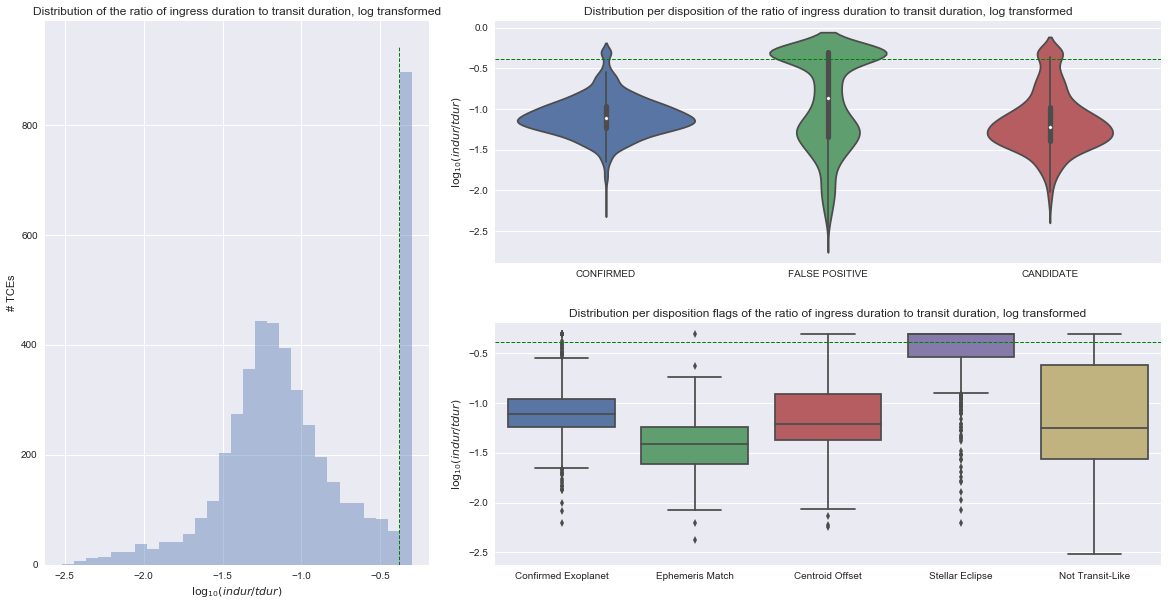

In [25]:
indur_tdur_ratio_maxthresh = -0.38
eda_plot_dist(df, 
              var='indur_tdur_ratio_log10', 
              var_label='$\log_{10}(indur/tdur)$', 
              var_title='ratio of ingress duration to transit duration, log transformed', 
              min_threshold=None,
              max_threshold=indur_tdur_ratio_maxthresh
             )

The stellar eclipse false positives have significantly higher ratio of ingress duration to transit duration ratio. 

By engineering the threshold indicator variable represented by the green dashed line, we can easely identify most of them:

> 1 when \\(log_{10}(indur\_tdur\_ratio) \geq -0.38\\)  
> 0 else

Note that they are some candidates above this threshold meaning they are probably not strong candidates...

In [26]:
# Engineer the threshold indicator variable
df['indur_tdur_ratio_maxthresh'] = (df.indur_tdur_ratio_log10 >= indur_tdur_ratio_maxthresh).astype(int) 

# Print some statistics
n_exoplanets = df[(df.koi_disposition == 'CONFIRMED') & (df.indur_tdur_ratio_log10 >= indur_tdur_ratio_maxthresh)].shape[0]
n_false_positives = df[(df.koi_disposition == 'FALSE POSITIVE') & (df.indur_tdur_ratio_log10 >= indur_tdur_ratio_maxthresh)].shape[0]
print('Number of identified false positives: ', n_false_positives)
print('Number of identified exoplanets: ', n_exoplanets)
print('False positives identification ratio: ', np.round(1 - n_exoplanets/n_false_positives, 3))

Number of identified false positives:  817
Number of identified exoplanets:  24
False positives identification ratio:  0.971


### 2.4 Ratio of the transit duration to the transit period

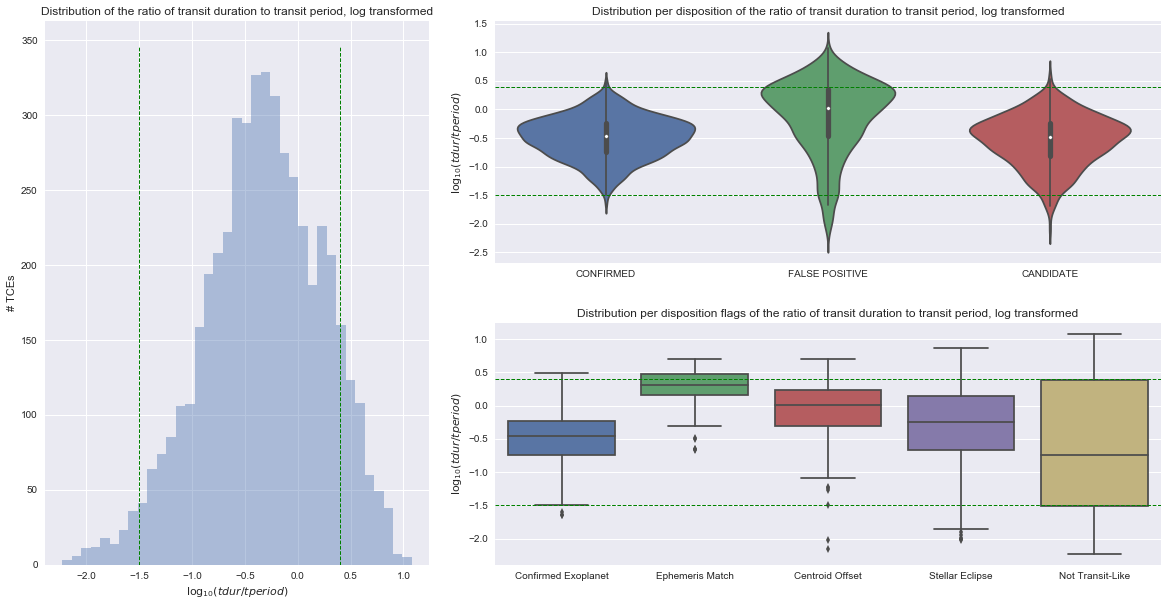

In [27]:
tdur_tperiod_ratio_minthresh = -1.5
tdur_tperiod_ratio_maxthresh = 0.4
eda_plot_dist(df, 
              var='tdur_tperiod_ratio_log10', 
              var_label='$\log_{10}(tdur/tperiod)$', 
              var_title='ratio of transit duration to transit period, log transformed', 
              min_threshold=tdur_tperiod_ratio_minthresh,
              max_threshold=tdur_tperiod_ratio_maxthresh
             )

The ephemeris match false positives have significantly higher ratio. The not transit-like false positive distribution is particularly interesting. They are well spreaded with a mean significantly bellow the exoplanet mean but with 50% of them appearing as extreme values in regards of the exoplanet range.

By engineering the two threshold indicator variables represented by the green dashed lines, we can easely identify more than 25% of the ephemeris match and 50% of the not transit-like false positives:

> 1 when \\(log_{10}(tdur\_tperiod\_ratio) \geq 0.4\\)  
> 0 else

> 1 when \\(log_{10}(tdur\_tperiod\_ratio) \leq -1.5\\)  
> 0 else

In [28]:
# Engineer the threshold indicator variable
df['tdur_tperiod_ratio_minthresh'] = (df.tdur_tperiod_ratio_log10 <= tdur_tperiod_ratio_minthresh).astype(int) 
df['tdur_tperiod_ratio_maxthresh'] = (df.tdur_tperiod_ratio_log10 >= tdur_tperiod_ratio_maxthresh).astype(int) 

# Print some statistics
n_exoplanets = df[(df.koi_disposition == 'CONFIRMED') & (df.tdur_tperiod_ratio_log10 >= tdur_tperiod_ratio_maxthresh)].shape[0]
n_false_positives = df[(df.koi_disposition == 'FALSE POSITIVE') & (df.tdur_tperiod_ratio_log10 >= tdur_tperiod_ratio_maxthresh)].shape[0]

print('Above max threshold statistics')
print('------------------------------')
print('Number of identified false positives: ', n_false_positives)
print('Number of identified exoplanets: ', n_exoplanets)
print('False positives identification ratio: ', np.round(1 - n_exoplanets/n_false_positives, 3))

n_exoplanets = df[(df.koi_disposition == 'CONFIRMED') & (df.tdur_tperiod_ratio_log10 <= tdur_tperiod_ratio_minthresh)].shape[0]
n_false_positives = df[(df.koi_disposition == 'FALSE POSITIVE') & (df.tdur_tperiod_ratio_log10 <= tdur_tperiod_ratio_minthresh)].shape[0]

print('\nBelow min threshold statistics')
print('------------------------------')
print('Number of identified false positives: ', n_false_positives)
print('Number of identified exoplanets: ', n_exoplanets)
print('False positives identification ratio: ', np.round(1 - n_exoplanets/n_false_positives, 3))

Above max threshold statistics
------------------------------
Number of identified false positives:  471
Number of identified exoplanets:  5
False positives identification ratio:  0.989

Below min threshold statistics
------------------------------
Number of identified false positives:  100
Number of identified exoplanets:  3
False positives identification ratio:  0.97


### 2.5 Transit depth

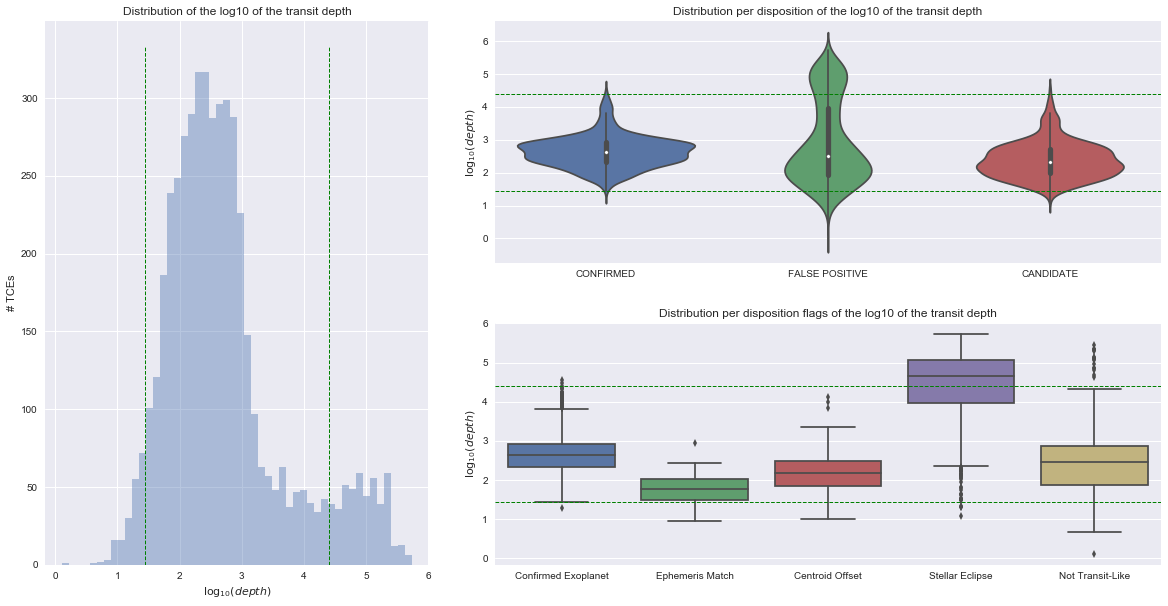

In [29]:
tdepth_minthresh = 1.45
tdepth_maxthresh = 4.4
eda_plot_dist(df, 
              var='tdepth_log10', 
              var_label='$\log_{10}(depth)$', 
              var_title='log10 of the transit depth', 
              min_threshold=tdepth_minthresh,
              max_threshold=tdepth_maxthresh
             )

The transit depth appears to be also a strong predictor. The higher transit depth of the stellar eclipse false positives can probably be explained by the fact that stars beeing bigger than planets, the eclipses are more often total / less partial, resulting to a deeper brightness dimming.

By engineering the two threshold indicator variables represented by the green dashed lines, we can easely identify more than 50% of the stellar eclipse and about 25% of the ephemeris match :

> 1 when \\(log_{10}(tdepth) \geq 4.4\\)  
> 0 else

> 1 when \\(log_{10}(tdepth) \leq 1.45\\)  
> 0 else

In [30]:
# Engineer the threshold indicator variable
df['tdepth_minthresh'] = (df.tdepth_log10 <= tdepth_minthresh).astype(int) 
df['tdepth_maxthresh'] = (df.tdepth_log10 >= tdepth_maxthresh).astype(int) 

# Print some statistics
n_exoplanets = df[(df.koi_disposition == 'CONFIRMED') & (df.tdepth_log10 >= tdepth_maxthresh)].shape[0]
n_false_positives = df[(df.koi_disposition == 'FALSE POSITIVE') & (df.tdepth_log10 >= tdepth_maxthresh)].shape[0]

print('Above max threshold statistics')
print('------------------------------')
print('Number of identified false positives: ', n_false_positives)
print('Number of identified exoplanets: ', n_exoplanets)
print('False positives identification ratio: ', np.round(1 - n_exoplanets/n_false_positives, 3))

n_exoplanets = df[(df.koi_disposition == 'CONFIRMED') & (df.tdepth_log10 <= tdepth_minthresh)].shape[0]
n_false_positives = df[(df.koi_disposition == 'FALSE POSITIVE') & (df.tdepth_log10 <= tdepth_minthresh)].shape[0]

print('\nBelow min threshold statistics')
print('------------------------------')
print('Number of identified false positives: ', n_false_positives)
print('Number of identified exoplanets: ', n_exoplanets)
print('False positives identification ratio: ', np.round(1 - n_exoplanets/n_false_positives, 3))

Above max threshold statistics
------------------------------
Number of identified false positives:  450
Number of identified exoplanets:  3
False positives identification ratio:  0.993

Below min threshold statistics
------------------------------
Number of identified false positives:  175
Number of identified exoplanets:  2
False positives identification ratio:  0.989


A study of the TCEs identified by the threshold indicator variables engineered until now shows that these two new variables are valuable allowing to identify new false positives :

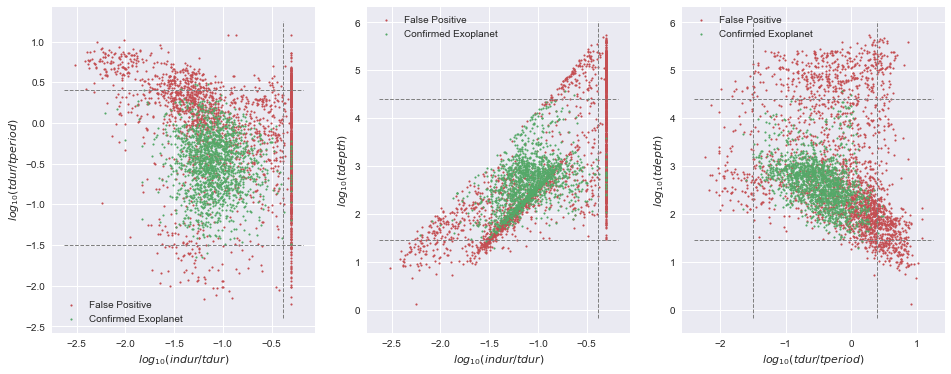

In [31]:
# Draw combination of scatter plots: indur_tdur_ratio_log10, tdur_tperiod_ratio_log10, tdepth_log10
# -----------

# exoplanet & false positive filters
false_positives = df.koi_disposition == 'FALSE POSITIVE'
exoplanets = df.koi_disposition == 'CONFIRMED'

# scatter plots params
plots = [('indur_tdur_ratio_log10', 'tdur_tperiod_ratio_log10', '$log_{10}(indur/tdur)$', '$log_{10}(tdur/tperiod)$', indur_tdur_ratio_maxthresh, [tdur_tperiod_ratio_minthresh, tdur_tperiod_ratio_maxthresh]), 
         ('indur_tdur_ratio_log10', 'tdepth_log10', '$log_{10}(indur/tdur)$', '$log_{10}(tdepth)$', indur_tdur_ratio_maxthresh, [tdepth_minthresh, tdepth_maxthresh]), 
         ('tdur_tperiod_ratio_log10', 'tdepth_log10', '$log_{10}(tdur/tperiod)$', '$log_{10}(tdepth)$', [tdur_tperiod_ratio_minthresh, tdur_tperiod_ratio_maxthresh], [tdepth_minthresh, tdepth_maxthresh])]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
for i in range(3):
    xvar, yvar, xlabel, ylabel, xthresh, ythresh = plots[i]
    ax[i].scatter(df.loc[false_positives, xvar], df.loc[false_positives, yvar], s=3, color=red, label='False Positive')
    ax[i].scatter(df.loc[exoplanets, xvar], df.loc[exoplanets, yvar], s=3, color=green, label='Confirmed Exoplanet')
    ax[i].set_xlabel(xlabel)
    ax[i].set_ylabel(ylabel)
    # plot thresholds
    if xthresh:
        ax[i].plot([xthresh, xthresh], ax[i].get_ylim(), color='gray', linestyle='--', linewidth=1)
    if ythresh:
        ax[i].plot(ax[i].get_xlim(), [ythresh, ythresh], color='gray', linestyle='--', linewidth=1)
    ax[i].legend()

The engineered threshold indicator variables do a good job to identify the false positives, especially the stellar eclipse ones.

A 3D scatter plot give good insight about the topologies of the clusters: 

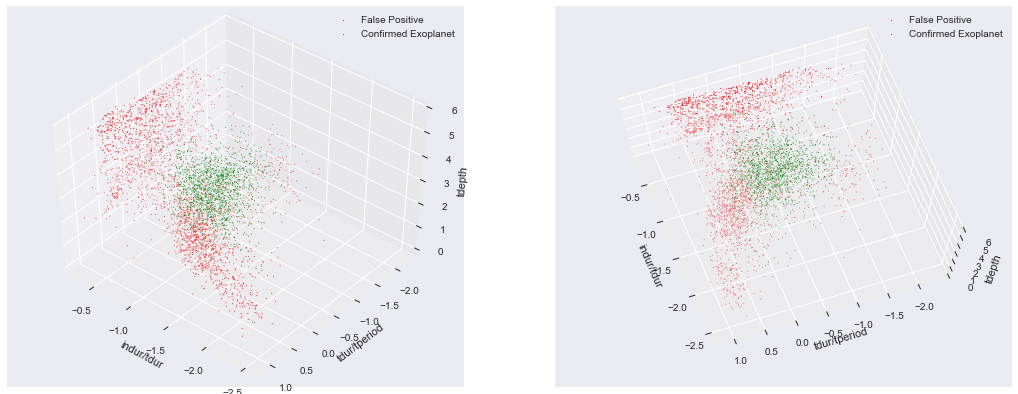

In [32]:
# 3d scatter plot
scatter_3d(df, 
           'indur_tdur_ratio_log10', 
           'tdur_tperiod_ratio_log10', 
           'tdepth_log10', 
           [(45, 130), (75, 160)], 
           'indur/tdur', 
           'tdur/tperiod', 
           'tdepth')

Without knowning the project, I would guess this plot related to the "Lac Leman" and "Jura"... :)

* The stellar eclispses form the "wall" cluster
* On the right plot, the left cluster are mostly ephemeris match and not transit-like false positives
* the rigth cluster are mostly not transit-like false positives

Until now, we have not been able to identify the centroid offset subcategories of false positives...

### 2.6 Location and next steps

We could procede the same for all other features but the new threshold variables would suffer some diminushing returns. The following features appear to be weak and uninteresting predictors, so their analysis are not presented in this notebook:

* all the magnitudes variables, presenting no trend at all
* the motion features, most of the TCEs have no motion

However, plotting a map of the location of each star, their declination VS their right ascension proved to be interesting:

In [33]:
# Load the location data
query = '''
SELECT
    ts.kepoi_name,
    ts.kepid,
    ts.fpflag_bitstring,
    kois.koi_disposition,
    loc.ra_obj,
    loc.dec_obj
FROM
         tce_status AS ts
    JOIN location_motion AS loc ON (ts.kepid = loc.kepid)
    JOIN kois_activity_table AS kois ON (ts.kepoi_name = kois.kepoi_name)
WHERE
    ts.excluded = 0
'''
df_loc = pd.read_sql_query(query, db)
print('KOIs Activity Table Shape:', df_loc.shape)
df_loc.head()

KOIs Activity Table Shape: (4875, 6)


,kepoi_name,kepid,fpflag_bitstring,koi_disposition,ra_obj,dec_obj
0,K00752.01,010797460,0000,CONFIRMED,291.93423,48.14165
1,K00752.02,010797460,0000,CONFIRMED,291.93423,48.14165
2,K00755.01,010854555,0000,CONFIRMED,288.75489,48.22620
3,K00114.01,006721123,0110,FALSE POSITIVE,298.86434,42.15157
4,K00010.01,006922244,0000,CONFIRMED,281.28812,42.45108


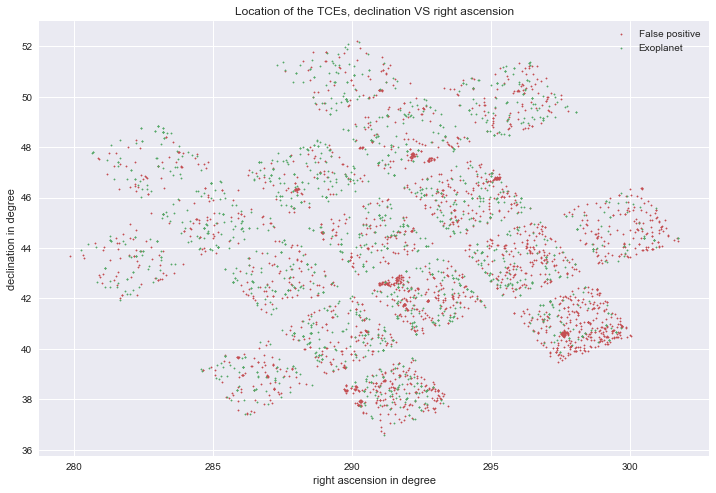

In [34]:
# Scatter plot of the declination VS right ascension
fp_filter = (df_loc.koi_disposition == 'FALSE POSITIVE')
ex_filter = (df_loc.koi_disposition == 'CONFIRMED')

plt.figure(figsize=(12, 8))
plt.scatter(df_loc.ra_obj[fp_filter], df_loc.dec_obj[fp_filter], s=2, color=red, label='False positive')
plt.scatter(df_loc.ra_obj[ex_filter], df_loc.dec_obj[ex_filter], s=2, color=green, label='Exoplanet')
plt.xlabel('right ascension in degree')
plt.ylabel('declination in degree')
plt.title('Location of the TCEs, declination VS right ascension')
plt.legend()
plt.show()

There are 17 regions as the number of the quarters and reorientation of the Kepler Space Telescope. We can see that the regions at the lowest declination and highest right ascension tend to have more false positives.

I think it could be the consequence of a higher density of stars in these regions, pointing towards the center of the galaxy that could increase the detection of centroid offset and stellar eclipse false positives.

Instead of keeping the `ra_obj` and `dec_obj` features to train our models, it could be interesting to engineer a categorical variable attributing to each TCEs the cluster ID they belongs to. It's a good opportunity to train a KMeans unsupervised learning classification model:

In [35]:
from sklearn.cluster import KMeans

# Features array
X = df_loc.loc[:, ['ra_obj', 'dec_obj']].values

# Train KMeans model
kmeans = KMeans(n_clusters=17, random_state=0)
kmeans.fit(X)

# Get the cluster centroids
centroids = kmeans.cluster_centers_[0]

# Get the prediction
cluster_pred = kmeans.predict(X)

The cluster centroids are not ordered; we will order them and remap the predictions accordingly by following these rules:

* the rows will be indexed from top to bottom as 10, 20, 30, 40, 50
* the columns will be indexed from left to right as 1, 2, 3, 4, 5

The cluster ID will be the sum of these indices, e.g, the cluster at the center will have the ID 32.

In [36]:
# Remap the predictions according to the wished cluster numbers
cluster_map = {
    10: 12,
     8: 14,
    11: 21,
     2: 22,
     3: 23,
    15: 24,
     5: 25,
    13: 32,
     7: 33,
    12: 34,
     0: 41,
    14: 42,
    16: 43,
     1: 44,
     9: 45,
     4: 52,
     6: 54
}
df_loc['location_cluster'] = pd.Series(cluster_pred).map(cluster_map).values

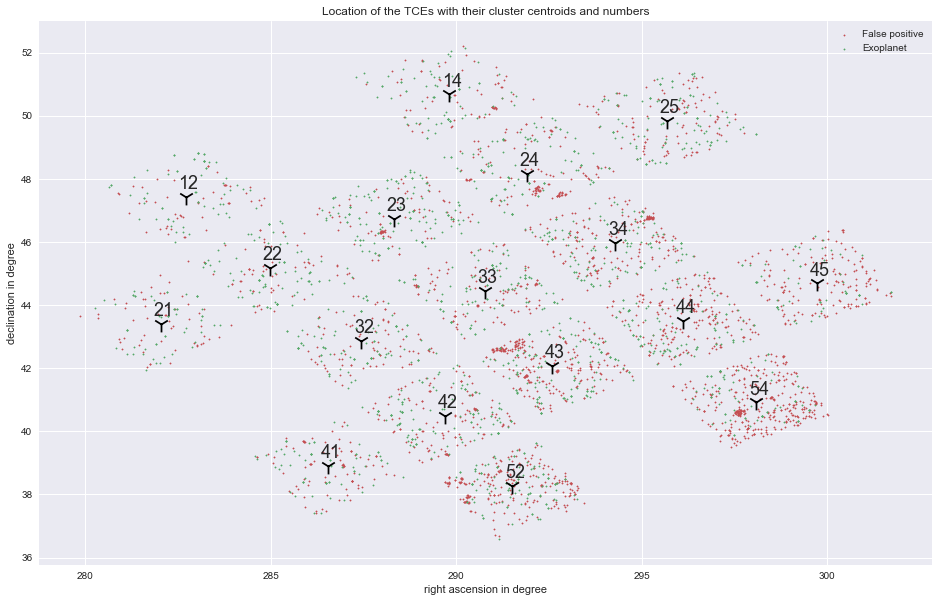

In [37]:
# Scatter plot of the declination VS right ascension with the cluster centroids and remapped IDs
plt.figure(figsize=(16, 10))
plt.scatter(df_loc.ra_obj[fp_filter], df_loc.dec_obj[fp_filter], s=2, color=red, label='False positive')
plt.scatter(df_loc.ra_obj[ex_filter], df_loc.dec_obj[ex_filter], s=2, color=green, label='Exoplanet')

i = 0
for centroid in kmeans.cluster_centers_:
    ra = centroid[0]
    dec = centroid[1]
    plt.scatter(ra, dec, s=250, color='black', marker='1')
    plt.text(ra - 0.2, dec + 0.25, s=cluster_map[i], fontsize=18)
    i += 1
    
plt.xlabel('right ascension in degree')
plt.ylabel('declination in degree')
plt.title('Location of the TCEs with their cluster centroids and numbers')
plt.legend()
plt.show()

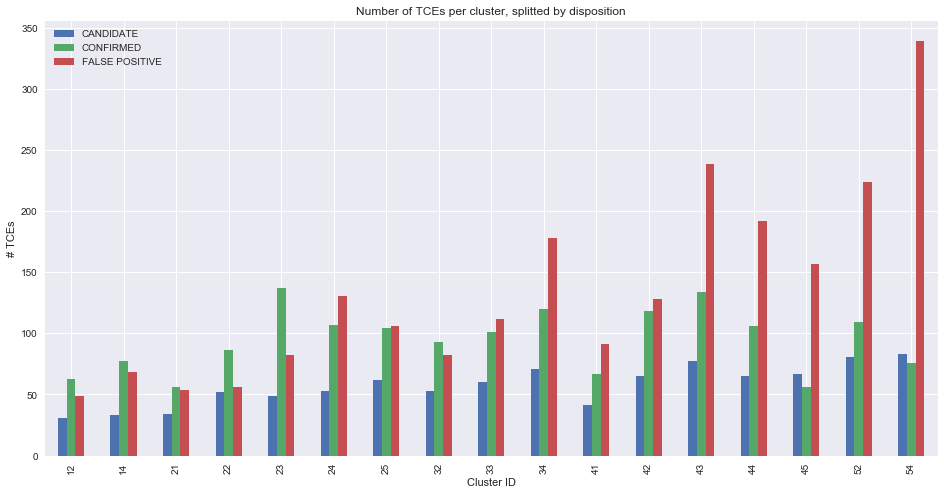

In [38]:
# Bar plot of the number of TCEs per cluster, splitted by disposition
df_loc.groupby(by=['location_cluster'])['koi_disposition'].value_counts() \
    .unstack() \
    .plot(kind='bar', stacked=False, figsize=(16, 8))
plt.xlabel('Cluster ID')
plt.ylabel('# TCEs')
plt.title('Number of TCEs per cluster, splitted by disposition')
plt.legend(title='')
plt.show()

Clusters with an ID greater than 42 have significantly more false positive TCEs and clusters with an ID bellow 23 less.

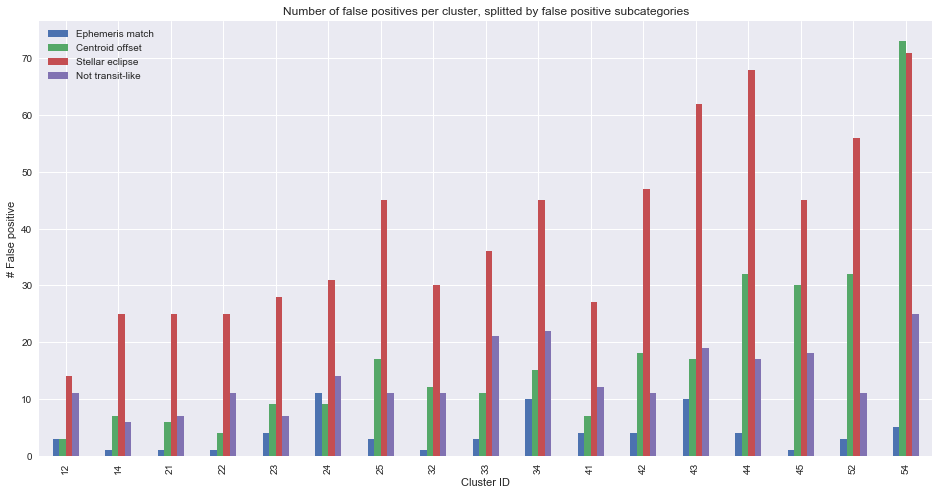

In [39]:
# Bar plot of the number of false positves per cluster, splitted by false positive subcategories
filter = df_loc.fpflag_bitstring.isin(['0001', '0010', '0100', '1000'])
df_loc.loc[filter, :].groupby(by=['location_cluster'])['fpflag_bitstring'].value_counts() \
    .unstack() \
    .plot(kind='bar', stacked=False, figsize=(16, 8))

labels = ['Ephemeris match', 'Centroid offset', 'Stellar eclipse', 'Not transit-like']

plt.xlabel('Cluster ID')
plt.ylabel('# False positive')
plt.title('Number of false positives per cluster, splitted by false positive subcategories')
plt.legend(title='', labels=labels)
plt.show()

The number of false positives per clusters, splitted by their subcategories shows that the clusters with the highest rigth ascension and lowest declination (clusters > 43) contains significantly more centroid offset false positives.

We will engineer an indicator variable identifying these clusters :

In [40]:
# Engineer an indicator variable identifying the clusters with more centroid offset false positives
df_loc['location_cluster_fpco'] = 0
df_loc.loc[df_loc.location_cluster > 43, 'location_cluster_fpco'] = 1

### 2.7 Save the engineered features in the database

In [41]:
# list of engineered variables
cols = [
    'tperiod_log10',
    'tdepth_log10',
    'tdur_log10',
    'indur_log10',
    'indur_tdur_ratio_log10',
    'tdur_tperiod_ratio_log10',
    'indur_tdur_ratio_maxthresh',
    'tdur_tperiod_ratio_minthresh',
    'tdur_tperiod_ratio_maxthresh',
    'tdepth_minthresh',
    'tdepth_maxthresh',
    'location_cluster',
    'location_cluster_fpco'
]

# save the engineered variable in a temporary table
df['location_cluster'] = df_loc.location_cluster
df['location_cluster_fpco'] = df_loc.location_cluster_fpco
df.loc[:, ['kepoi_name'] + cols].to_sql(name='temp', con=db, if_exists='replace', index=False)

# add columns in the status database table
query = "ALTER TABLE tce_status ADD COLUMN tperiod_log10 REAL;"
cursor.execute(query)
query = "ALTER TABLE tce_status ADD COLUMN tdepth_log10 REAL;"
cursor.execute(query)
query = "ALTER TABLE tce_status ADD COLUMN tdur_log10 REAL;"
cursor.execute(query)
query = "ALTER TABLE tce_status ADD COLUMN indur_log10 REAL;"
cursor.execute(query)
query = "ALTER TABLE tce_status ADD COLUMN indur_tdur_ratio_log10 REAL;"
cursor.execute(query)
query = "ALTER TABLE tce_status ADD COLUMN tdur_tperiod_ratio_log10 REAL;"
cursor.execute(query)
query = "ALTER TABLE tce_status ADD COLUMN indur_tdur_ratio_maxthresh INTEGER DEFAULT 0;"
cursor.execute(query)
query = "ALTER TABLE tce_status ADD COLUMN tdur_tperiod_ratio_minthresh INTEGER DEFAULT 0;"
cursor.execute(query)
query = "ALTER TABLE tce_status ADD COLUMN tdur_tperiod_ratio_maxthresh INTEGER DEFAULT 0;"
cursor.execute(query)
query = "ALTER TABLE tce_status ADD COLUMN tdepth_minthresh INTEGER DEFAULT 0;"
cursor.execute(query)
query = "ALTER TABLE tce_status ADD COLUMN tdepth_maxthresh INTEGER DEFAULT 0;"
cursor.execute(query)
query = "ALTER TABLE tce_status ADD COLUMN location_cluster INTEGER;"
cursor.execute(query)
query = "ALTER TABLE tce_status ADD COLUMN location_cluster_fpco INTEGER DEFAULT 0;"
cursor.execute(query)

# load the data 
for col in cols:
    query = "UPDATE tce_status SET " + col + " = (SELECT " + col + " FROM temp WHERE tce_status.kepoi_name = temp.kepoi_name);" 
    cursor.execute(query)
    
# Commit the transsactions
db.commit()

## 3. Summary

As expected, we found strong predictors among the transit parameters features. Most of them must be log transformed to have near normal distribution. By the engineering of many threshold indicator variables, we have been able to define already good boundaries between the different false positive clusters and the confirmed exoplanets. Thank to the ratio of ingress duration to transit duration and ratio of transit duration to transit period engineered features better than the individual features from which they are computed. 

The overall EDA has allowed us to gain insight about the data, clean them and engineer many interesting features.  
We can now prepare the final datasets that will be used to train and test the models.